# Data Science Ethics Checklist

[![Deon badge](https://img.shields.io/badge/ethics%20checklist-deon-brightgreen.svg?style=popout-square)](http://deon.drivendata.org/)

> The goals of this notebook exercise are (1) to practice integrating the `deon` checklist into your code, and (2) to learn how to use a few basic data science tools in python.

This notebook is for the Eviction Data Case Study exercise in the "Actionable Ethics for Data Scientists" workshop for the data science MSc at the University of Buckingham.

Instructions

- We'll walk through the notebook as a group, and break for independent work where there is a <span style="color:green">**\*\*bolded green heading for "Activity" or "Discussion"\*\***</span>.

- If you need help debugging during any of the exercises, post in the Teams thread for this workshop or send a direct message to one of the DrivenData team members. **We encourage you to work together!**

- There is a more comprehensive version of the case study notebook in `notebooks/eviction-data-case-study-reference.ipynb`. You can refer to this if you are stumped during any of the coding exercises, but we strongly encourage solving problems on your own first!

**We will not discuss every item on the deon checklist - items have been chosen that illustrate interesting points or coding challenges.** In real-world setting, you'll want to integrate the full deon checklist into your coding. You can see an example of this in the workshop repository.


## Background

Over the past five decades, [housing costs have risen faster than incomes](http://www.jchs.harvard.edu/state-nations-housing-2018), low-cost housing has been disappearing from the market, and racial disparities in homeownership rates have deepened. This has put many in a perilous situation. As the [Eviction Lab](https://evictionlab.org/why-eviction-matters/#affordable-housing-crisis) explains:

> Today, most poor renting families spend at least half of their income on housing costs, with one in four of those families spending over 70 percent of their income just on rent and utilities. Only one in four families who qualify for affordable housing programs get any kind of help. Under those conditions, it has become harder for low-income families to keep up with rent and utility costs, and a growing number are living one misstep or emergency away from eviction.


## Objective

A non-profit dedicated to helping people at risk of eviction in California has tasked us to build a model to estimate the number of eviction cases by geography, based on socioeconomic data. They would like to use these estimates to help them prioritize where to commit funding and resources.

We will be using a subset of the eviction dataset published by the [Eviction Lab](https://evictionlab.org/) at Princeton University. The subset is the census-tract-level aggregates for only tracts in the state of California. 

## Set up

Import necessary python packages

In [1]:
%load_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import seaborn as sns
import wget

%matplotlib inline
pd.set_option("display.max_columns", 30)

## Loading the Data

In [3]:
DATA_URL = "https://drivendata-public-assets.s3.amazonaws.com/odsc-west-2019/california-tracts.csv"
DATA_PATH = "../data/raw/california-tracts.csv"

# Set standard fig size for plots
FIGSIZE = (10, 10)

In [4]:
if not os.path.exists(DATA_PATH):
    # Download data
    wget.download(url=DATA_URL, out=DATA_PATH)

#### Exploratory data analysis

In [5]:
df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)
print("\nData types:\n", df.dtypes)
df.head()

Data shape: (136958, 27)

Data types:
 GEOID                           int64
year                            int64
name                          float64
parent-location                object
population                    float64
poverty-rate                  float64
renter-occupied-households    float64
pct-renter-occupied           float64
median-gross-rent             float64
median-household-income       float64
median-property-value         float64
rent-burden                   float64
pct-white                     float64
pct-af-am                     float64
pct-hispanic                  float64
pct-am-ind                    float64
pct-asian                     float64
pct-nh-pi                     float64
pct-multiple                  float64
pct-other                     float64
eviction-filings              float64
evictions                     float64
eviction-rate                 float64
eviction-filing-rate          float64
low-flag                        int64
imputed    

,GEOID,year,name,parent-location,population,poverty-rate,renter-occupied-households,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,rent-burden,pct-white,pct-af-am,pct-hispanic,pct-am-ind,pct-asian,pct-nh-pi,pct-multiple,pct-other,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed
0,6001400100,2000,4001.0,"Alameda County, California",2497.87,2.93,108.0,9.43,1913.0,133272.0,695900.0,22.8,77.54,4.56,3.88,0.16,11.21,0.2,2.2,0.24,0.0,0.0,0.00,0.00,1,0,0
1,6001400100,2001,4001.0,"Alameda County, California",2497.87,2.93,117.0,9.43,1913.0,133272.0,695900.0,22.8,77.54,4.56,3.88,0.16,11.21,0.2,2.2,0.24,1.0,0.0,0.00,0.86,1,0,0
2,6001400100,2002,4001.0,"Alameda County, California",2497.87,2.93,126.0,9.43,1913.0,133272.0,695900.0,22.8,77.54,4.56,3.88,0.16,11.21,0.2,2.2,0.24,1.0,1.0,0.80,0.80,1,0,0
3,6001400100,2003,4001.0,"Alameda County, California",2497.87,2.93,134.0,9.43,1913.0,133272.0,695900.0,22.8,77.54,4.56,3.88,0.16,11.21,0.2,2.2,0.24,2.0,2.0,1.49,1.49,1,0,0
4,6001400100,2004,4001.0,"Alameda County, California",2497.87,2.93,143.0,9.43,1913.0,133272.0,695900.0,22.8,77.54,4.56,3.88,0.16,11.21,0.2,2.2,0.24,0.0,0.0,0.00,0.00,1,0,0


In [6]:
# count = non-NaN observations; size = all observations
df.groupby("year").agg(
    count=("eviction-rate", "count"), size=("eviction-rate", "size")
).transpose()

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,6622,6943,6871,6697,6584,6553,7018,7190,7190,7364,7254,6369,6335,6327,6739,6551,6615
size,8056,8056,8056,8056,8056,8056,8056,8056,8056,8056,8056,8057,8057,8057,8057,8057,8057


In [7]:
# Data Dictionary
DATA_DICT_URL = "https://drivendata-public-assets.s3.amazonaws.com/odsc-west-2019/DATA_DICTIONARY.txt"
DATA_DICT_PATH = "../references/DATA_DICTIONARY.txt"

if not os.path.exists(DATA_DICT_PATH):
    # Download data dictionary
    wget.download(url=DATA_DICT_URL, out=DATA_DICT_PATH)

In [8]:
!cat $DATA_DICT_PATH

Eviction Lab Data Dictionary

Additional information in our FAQ evictionlab.org/help-faq/
Full methodology evictionlab.org/methods/

Notes:
- All geographies are converted to their 2010 Census FIPS codes, names, and boundaries

Variables:

- GEOID
    - Census FIPS code
- name
    - Census location name (modified for display on map)
- parent-location
    - Parent location of given geography.
    - USA for states, state for counties and cities, counties for tracts and block groups
- population
    - Total population
    - 2000-2004 use 2000 Census SF1 P001001
    - 2005-2009 use 2009 5-year ACS B01003_001E
    - 2010 uses 2010 Census P0030001
    - 2011-2016 uses 2015 5-year ACS B01003_001E
- poverty-rate
    - % of the population with income in the past 12 months below the poverty level
    - 2000-2004 divides P087002 by P087001 in the 2000 Census summary file 3
    - 2005-2009 divides B17010_002E by B17010_001E in 2009 5-year ACS
    - 2010 divides B17010_002E by B17010_001E in 2012 5

## A. Data Collection

- [ ] **A.1 Informed consent**: If there are human subjects, have they given informed consent, where subjects affirmatively opt-in and have a clear understanding of the data uses to which they consent?

We are not directly collecting any data from human subjects. We are using a well-known, publicly published dataset published by a well-known research laboratory at a prestigious research university. The university has strong data protection guidelines documented [here](https://ria.princeton.edu/research-data-security). Furthermore, the data represents public records such as court records and census data. 

 - [ ] **A.2 Collection bias**: Have we considered sources of bias that could be introduced during data collection and survey design and taken steps to mitigate those?

Data sources are reported by Eviction Lab [here](https://evictionlab.org/help-faq/#data-source). In their [methodology details](https://evictionlab.org/docs/Eviction%20Lab%20Methodology%20Report.pdf), they note that some observations are marked as "low", meaning that Eviction Lab believes they are undercounted based on comparisons against county-level aggregate data reported by states. 

There has also been some further criticism from housing activists that Eviction Lab is undercounting evictions when compared against data from local activist organizations, especially informal evictions that don't go through the formal legal process. See:

1. https://shelterforce.org/2018/08/22/eviction-lab-misses-the-mark/
2. https://chieforganizer.org/2018/08/28/the-cracks-in-the-eviction-lab-wall-are-undercounting-the-crisis/

# TODO - add note about framing

 - [ ] **A.3 Limit PII exposure**: Have we considered ways to minimize exposure of personally identifiable information (PII) for example through anonymization or not collecting information that isn't relevant for analysis?

The dataset we are using is aggregated at the census tract level and does not directly have PII in it. The Eviction Lab has individual household data but does not make those available publicly. Again, the university has strong data protection guidelines documented [here](https://ria.princeton.edu/research-data-security).

More generally, one potential pitfall is that in situations where groups are very small, there is potential to infer or associate information to individuals. We can actually see in the data that some tracts have very small counts of renter households. However, we don't have any PII-relevant fields in this dataset, and identification in this case would involve joining to other datasets that could independently be used to identify people. 

In [9]:
# how possible is it to de-anonymize the data? How many small tracts do we have?
df["renter-occupied-households"].describe(percentiles=[0.001, 0.01, 0.05, 0.10])

count    136952.000000
mean        674.824800
std         492.442191
min           0.000000
0.1%          0.000000
1%            6.000000
5%          102.000000
10%         160.000000
50%         574.000000
max        6156.000000
Name: renter-occupied-households, dtype: float64

 - [ ] **A.4 Downstream bias mitigation:** Have we considered ways to enable testing downstream results for biased outcomes (e.g., collecting data on protected group status like race or gender)?

We have information about the racial makeup of each tract in the data. This means that after we fit our model, we can assess whether model performance varies strongly between different racial groups.

## B. Data Storage

 - [ ] **B.1 Data security**: Do we have a plan to protect and secure data (e.g., encryption at rest and in transit, access controls on internal users and third parties, access logs, and up-to-date software)?

Since we are using a public dataset, this is not applicable.

 - [ ] **B.2 Right to be forgotten**: Do we have a mechanism through which an individual can request their personal information be removed?

Since we are using a public dataset and not collecting data from subjects directly, this is not applicable.

 - [ ] **B.3 Data retention plan**: Is there a schedule or plan to delete the data after it is no longer needed?

Since we are using a public dataset, this is not applicable.

## C. Analysis

 - [ ] **C.1 Missing perspectives**: Have we sought to address blindspots in the analysis through engagement with relevant stakeholders (e.g., checking assumptions and discussing implications with affected communities and subject matter experts)?

As noted in A.2, there may be systemic undercounting of evictions due to the data collection process. In particular, for informal evictions that bypassed the formal legal process, there may be certain groups of people that an analysis based on this dataset is completely blind to. 

As a general rule, **any program should get significant input from the communities it is hoping to serve.** The individuals in these communities are always the best experts on their own needs. Transferring agency as much as possible to those in relevant communities helps to ensure a program is responding to real, everyday needs within a community. This is particularly relevant to consider if those administer or managing a program are not representative of the communities the program aims to serve.

 - [ ] **C.2 Dataset bias**: Have we examined the data for possible sources of bias and taken steps to mitigate or address these biases (e.g., stereotype perpetuation, confirmation bias, imbalanced classes, or omitted confounding variables)?

In [10]:
# Look into the number of missing values for a handful of relevant columns
df[["low-flag", "imputed", "evictions"]].isna().sum()

low-flag         0
imputed          0
evictions    21736
dtype: int64

In [11]:
# How many observations have the low-flag?
print(f"Proportion of observations with low-flag: {df['low-flag'].mean():.2f}")
df["low-flag"].value_counts()

Proportion of observations with low-flag: 0.72


1    98441
0    38517
Name: low-flag, dtype: int64

In [12]:
# How many observations have the imputed flag?
print(f"Proportion of observations with imputed flag: {df['imputed'].mean():.2f}")
df["imputed"].value_counts()

Proportion of observations with imputed flag: 0.01


0    135192
1      1766
Name: imputed, dtype: int64

In [13]:
# How many tracts are missing the number of evictions?
print(
    f"Proportion of Evictions Counts that are NA: {df['evictions'].isna().mean():.2f}"
)

Proportion of Evictions Counts that are NA: 0.16


In [14]:
# What are the eviction values generally?
df.evictions.describe()

count    115222.000000
mean         11.417629
std          14.838183
min           0.000000
25%           2.000000
50%           7.000000
75%          15.000000
max         296.000000
Name: evictions, dtype: float64

In [15]:
# What are the general values of the race columns?
race_cols = [
    "pct-white",
    "pct-af-am",
    "pct-hispanic",
    "pct-am-ind",
    "pct-asian",
    "pct-nh-pi",
    "pct-multiple",
    "pct-other",
]
df[race_cols].describe(percentiles=[])

,pct-white,pct-af-am,pct-hispanic,pct-am-ind,pct-asian,pct-nh-pi,pct-multiple,pct-other
count,136952.000000,136952.000000,136952.000000,136952.000000,136952.000000,136952.000000,136952.000000,136952.000000
mean,43.452164,5.994545,34.575192,0.472269,11.850210,0.325644,2.529993,0.253803
std,27.628941,9.969225,26.246277,1.463626,14.165121,0.864646,1.997365,0.544381
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,44.190000,2.470000,26.495000,0.200000,6.770000,0.030000,2.280000,0.090000
max,100.000000,92.340000,100.000000,82.190000,94.180000,24.740000,100.000000,14.150000


In [16]:
# Calculate pairwise correlation of some columns against race percentage columns
cols_to_correlate = ["evictions", "median-household-income", "imputed", "low-flag"]
correlation_df = (
    df[race_cols + cols_to_correlate].corr().loc[race_cols, cols_to_correlate]
)
correlation_df

,evictions,median-household-income,imputed,low-flag
pct-white,-0.234153,0.435938,0.005196,-0.108437
pct-af-am,0.271784,-0.227408,-0.003857,0.070013
pct-hispanic,0.212196,-0.490733,0.011387,0.045566
pct-am-ind,0.013909,-0.105474,0.008222,-0.052412
pct-asian,-0.117743,0.249954,-0.028211,0.079841
pct-nh-pi,0.050222,-0.025730,0.008283,0.025293
pct-multiple,-0.018113,0.197695,-0.008202,-0.005826
pct-other,0.014197,0.026264,0.018146,0.026254


<AxesSubplot:>

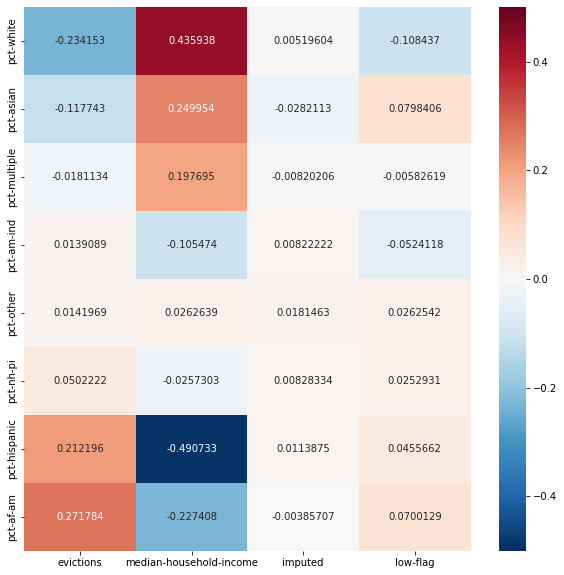

In [17]:
# Visualize the above correlations.
plt.figure(figsize=FIGSIZE)
sns.heatmap(
    correlation_df.sort_values("evictions"),
    annot=True,
    fmt="g",
    cmap="RdBu_r",
    vmin=-0.5,
    vmax=0.5,
)

 - [ ] **C.3 Honest representation**: Are our visualizations, summary statistics, and reports designed to honestly represent the underlying data?

We are not going to spend time in this exercise looking at examples of poor visualizations, but this is a good check to do for real projects.

 - [ ] **C.4 Privacy in analysis**: Have we ensured that data with PII are not used or displayed unless necessary for the analysis?

Mostly not applicable. We have no PII, but we do have some tracts with few observations. We need to be mindful of those and maybe exclude them from visualizations or combine them with neighboring tracts.

 - [ ] **C.5 Auditability**: Is the process of generating the analysis well documented and reproducible if we discover issues in the future?

Yes, all of our code is contained in this notebook. For real projects, this is an important point to consider in more depth.

## D. Modeling

The non-profit wants their decision-making to be race-blind, so they ask for the population race percentage features to not be included in the modeling.

In [18]:
TARGET_VAR = "evictions"
FEATURE_VARS = [
    "year",
    "population",
    "poverty-rate",
    "median-property-value",
    "renter-occupied-households",
    "pct-renter-occupied",
    "median-gross-rent",
    "median-household-income",
    "rent-burden",
    ## Don't include race features
    #'pct-white' , 'pct-af-am', 'pct-hispanic', 'pct-am-ind',
    #'pct-asian', 'pct-nh-pi', 'pct-multiple', 'pct-other'
    ## Also don't include features directly related to the target variable
    # 'eviction-filings', 'eviction-rate', 'eviction-filing-rate'
]
GROUP_VAR = "GEOID"  # Prevent leakage

In [19]:
print(f"Original Shape: {df.shape}")
# Drop NAs in target variable
df_modeling = df.dropna(subset=[TARGET_VAR]).copy()
df_modeling.reset_index(inplace=True)
print(f"Shape without NAs: {df_modeling.shape}")

Original Shape: (136958, 27)
Shape without NAs: (115222, 28)


In [20]:
from sklearn.model_selection import GroupShuffleSplit, cross_validate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [21]:
df_modeling.loc[:, TARGET_VAR].describe()

count    115222.000000
mean         11.417629
std          14.838183
min           0.000000
25%           2.000000
50%           7.000000
75%          15.000000
max         296.000000
Name: evictions, dtype: float64

In [22]:
# create a train-test split for model evaluation later
split = GroupShuffleSplit(test_size=0.20, n_splits=2, random_state=36).split(
    df_modeling, groups=df_modeling.loc[:, GROUP_VAR]
)

train_inds, test_inds = next(split)

df_train = df_modeling.loc[train_inds, :]
df_test = df_modeling.loc[test_inds, :]

X_train = df_train.loc[:, FEATURE_VARS].values
y_train = df_train.loc[:, TARGET_VAR].values

X_test = df_test.loc[:, FEATURE_VARS].values
y_test = df_test.loc[:, TARGET_VAR].values

In [23]:
%%time
# train the model
model_pipeline = Pipeline([
    ('med_impute', SimpleImputer(strategy='median')),
    ('model', RandomForestRegressor(
        criterion='mse',
        n_estimators=100, 
        max_depth=10,
        random_state=36
    ))
])
model_pipeline.fit(X_train, y_train)

/opt/anaconda3/envs/msc-buckingham-data-ethics/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


CPU times: user 30.1 s, sys: 238 ms, total: 30.3 s
Wall time: 32 s


Pipeline(steps=[('med_impute', SimpleImputer(strategy='median')),
                ('model',
                 RandomForestRegressor(criterion='mse', max_depth=10,
                                       random_state=36))])

In [24]:
# generate predictions and look at key performance metrics
y_pred = model_pipeline.predict(X_test)
print("R2", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("MAE", mean_absolute_error(y_test, y_pred))

R2 0.4902906447471631
MSE 102.05521224494476
MAE 5.9859944311932445


 - [ ] **D.1 Proxy discrimination**: Have we ensured that the model does not rely on variables or proxies for variables that are unfairly discriminatory?

Per the non-profit's request, we did not include any race variables in training our model. We want to figure out whether the model is still making decisions based on race using proxy variables that can indirectly indicate race.

***
### <span style="color:green">*Activity*</span>

> Work independently for 20-25 minutes. Start here and stop where "end of activity" is indicated

**<span style="color:green">To what extent are any of the feature variables in our model acting as proxies for race? Take some time to explore the data.</span>**

<span style="color:green">First, let's look for correlations between our feature variables and our race variables.</span>

<AxesSubplot:>

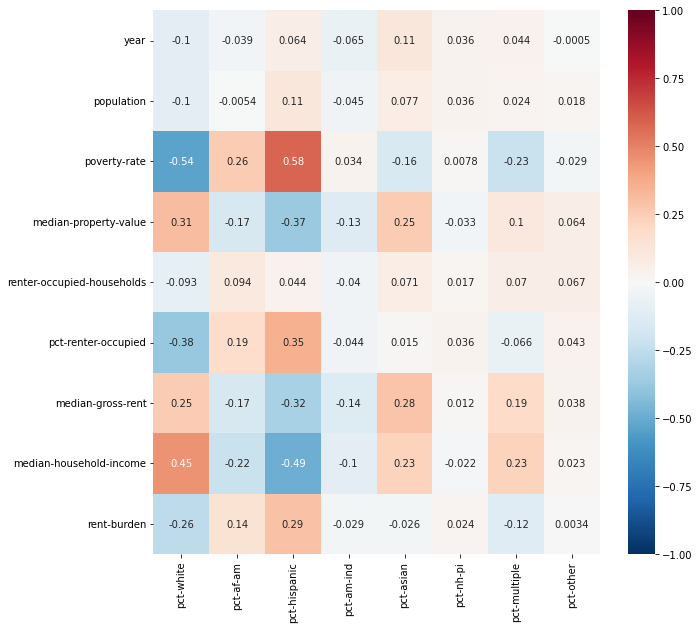

In [25]:
corr = df_modeling.loc[:, FEATURE_VARS + race_cols].corr().loc[FEATURE_VARS, race_cols]

plt.figure(figsize=FIGSIZE)
sns.heatmap(corr, vmin=-1.0, vmax=1.0, cmap="RdBu_r", annot=True)

**<span style="color:green">Takeaways</span>** 

- <span style="color:green">*Example takeaway:* poverty rate has a strong correlation with multiple race variables. It tends to be higher for tracts with a higher percent hispanic, and also higher but slightly less so for tracts with a higher percent African American. It tends to be lower in neighborhoods that are more white.</span>

- <span style="color:green">... your thoughts here ...</span>

<span style="color:green">We can use the correlation function's documentation to help with interpretation (below). You may want to look online for more details about any concepts in the documentation that you aren't familiar with, like pearson correlation coefficients.</span>

In [26]:
# run this to see documentation of the df.corr function
?df.corr

Signature:
df.corr(
    method: 'str | Callable[[np.ndarray, np.ndarray], float]' = 'pearson',
    min_periods: 'int' = 1,
) -> 'DataFrame'
Docstring:
Compute pairwise correlation of columns, excluding NA/null values.

Parameters
----------
method : {'pearson', 'kendall', 'spearman'} or callable
    Method of correlation:

    * pearson : standard correlation coefficient
    * kendall : Kendall Tau correlation coefficient
    * spearman : Spearman rank correlation
    * callable: callable with input two 1d ndarrays
        and returning a float. Note that the returned matrix from corr
        will have 1 along the diagonals and will be symmetric
        regardless of the callable's behavior.
min_periods : int, optional
    Minimum number of observations required per pair of columns
    to have a valid result. Currently only available for Pearson
    and Spearman correlation.

Returns
-------
DataFrame
    Correlation matrix.

See Also
--------
DataFrame.corrwith : Compute pairwise corr

<span style="color:green">Your turn to code!</span>

<span style="color:green">We have a lot of different race variables, some of which have fairly low rates in many areas. **What happens if we create an aggregated variable for the percent of all non-white residents (`pct-non-white`)? What do the feature variable correlations look like for `pct-non-white` compared to `pct-white`, and do any patterns become clearer?** *Hint:* You can accomplish most of this by reusing code from above.</span>

<span style="color:green">Remember to document any substantive choices you have to make when you define the `pct-non-white` variable, and who is included.</span>

<AxesSubplot:>

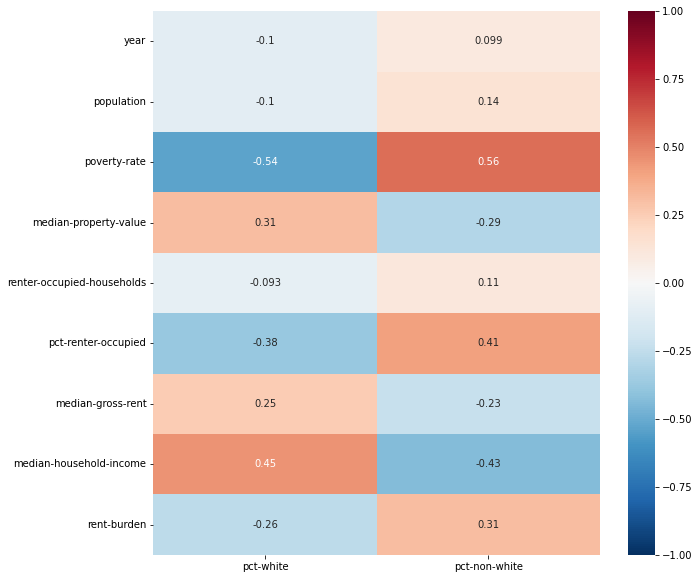

In [27]:
# create pct-non-white variable
# we choose not to include pct-multiple for clarity
df_modeling["pct-non-white"] = df_modeling[
    ["pct-af-am", "pct-hispanic", "pct-am-ind", "pct-asian", "pct-nh-pi", "pct-other"]
].sum(axis=1)

# plot correlations to feature variables
corr = (
    df_modeling.loc[:, FEATURE_VARS + ["pct-white", "pct-non-white"]]
    .corr()
    .loc[FEATURE_VARS, ["pct-white", "pct-non-white"]]
)

plt.figure(figsize=FIGSIZE)
sns.heatmap(corr, vmin=-1.0, vmax=1.0, cmap="RdBu_r", annot=True)

**<span style="color:green">Takeaways and notes</span>** 

- <span style="color:green">Above, we chose not to include `pct-multiple` in `pct-non-white` for clarity. Our thought process is that it's not clear how those individuals identify or how often they tend to pass as white, and we want to explicitly compare white communities to communities that have been clearly marginalized in the past.</span>

- <span style="color:green">For many variables, `pct-white` and `pct-non-white` have clearly opposite trends. Whiter neighborhoods have lower poverty rates, higher median property values, fewer renter-occupied homes, higher median household income, and lower rent burden. The opposite is true of neighborhoods with a higher percentage of residents who are non-white.</span>

<span style="color:green">Another strategy is to fit a model that predicts the percent of a given race based on feature variables. If that model performs well, we know that our model for eviction could also make accurate inferences about racial breakdowns within tracts.</span>

<span style="color:green">**Below, train a model that predicts `pct-white` based on the same `FEATURE_VARS` used to train our eviction model earlier. Then assess how well the model performs, and write up a few takeaways about what that means for race proxy variables in our eviction model.** Remember, you can reuse code from earlier steps.</span>

In [28]:
# create X_train, y_train, X_test, and y_test

# use the same train and test split as before, but change the target
# drop rows where pct-white is missing
pct_white_missing_mask = df_train["pct-white"].isna()
print(
    f"Dropping {pct_white_missing_mask.sum()} rows with missing data from the train set"
)
X_train_pct_white = df_train.loc[~pct_white_missing_mask, FEATURE_VARS].values
y_train_pct_white = df_train.loc[~pct_white_missing_mask, "pct-white"].values

pct_white_missing_mask = df_test["pct-white"].isna()
print(
    f"Dropping {pct_white_missing_mask.sum()} rows with missing data from the test set"
)
X_test_pct_white = df_test.loc[~pct_white_missing_mask, FEATURE_VARS].values
y_test_pct_white = df_test.loc[~pct_white_missing_mask, "pct-white"].values

Dropping 0 rows with missing data from the train set
Dropping 6 rows with missing data from the test set


In [29]:
%%time
# train a model to predict pct-white
model_pipeline_pct_white = Pipeline([
    ('med_impute', SimpleImputer(strategy='median')),
    ('model', RandomForestRegressor(
        criterion='mse',
        n_estimators=100, 
        max_depth=10,
        random_state=36
    ))
])
model_pipeline_pct_white.fit(X_train_pct_white, y_train_pct_white)

/opt/anaconda3/envs/msc-buckingham-data-ethics/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


CPU times: user 29.9 s, sys: 233 ms, total: 30.2 s
Wall time: 30.9 s


Pipeline(steps=[('med_impute', SimpleImputer(strategy='median')),
                ('model',
                 RandomForestRegressor(criterion='mse', max_depth=10,
                                       random_state=36))])

In [30]:
# calculate simple performance metrics (R2, MSE, MAE)
y_pred_pct_white = model_pipeline_pct_white.predict(X_test_pct_white)
print("R2", r2_score(y_test_pct_white, y_pred_pct_white))
print("MSE", mean_squared_error(y_test_pct_white, y_pred_pct_white))
print("MAE", mean_absolute_error(y_test_pct_white, y_pred_pct_white))

R2 0.5239107683230075
MSE 368.3845631795944
MAE 15.190578768438291


Text(0, 0.5, 'predicted % white')

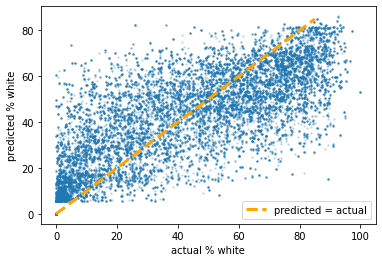

In [31]:
# code for any other exploration of model performance you'd like to do!
y_error = y_pred_pct_white - y_test_pct_white

plt.scatter(y_test_pct_white, y_pred_pct_white, s=2, alpha=0.2)
plt.plot(
    [0, 85], [0, 85], "--", linewidth=3, color="orange", label="predicted = actual"
)
plt.legend()
plt.xlabel("actual % white")
plt.ylabel("predicted % white")

**<span style="color:green">Takeaways</span>** 

- <span style="color:green">The model doesn't do a very good job of predicting percent white based on our feature variables. Based on the R-squared, it only captures 53% of the actual variance in the data.</span> 
- <span style="color:green">This doesn't necessarily mean proxy variables are not being used by the model, but a very preliminary indication shows that predicting percent white based just on our model feature variables is not super simple and easy.</span>


<span style="color:green">**End of activity, wait for group to reconvene and discuss**</span>

***

 - [ ] **D.2 Fairness across groups**: Have we tested model results for fairness with respect to different affected groups (e.g., tested for disparate error rates)?

### <span style="color:green">*Discussion*</span>

<span style="color:green">What are some approaches we can use to answer this question? Think about things like:</span> 

- <span style="color:green">How does the format of the data about race impact our strategy?</span> 
> *E.g. We have percents for each race in each tract, which is more complicated that if we had data points that were each associated with just one race.*


- <span style="color:green">What model performance metrics do we want to consider?</span> 
> *E.g. Absolute error can give us a sense of whether it performs better on certain groups than others. Raw error can tell us for which groups the model is likely to underpredict evictions, which could lead to fewer services being provided.*

- <span style="color:green">What visuals do we want to produce?</span>

***

### <span style="color:green">*Activity*</span>

> Work independently for 15-20 minutes. Start here and stop where "end of activity" is indicated

<span style="color:green">Calculate the correlation between each of the race variables in the model with error and absolute error. Remember that you can re-use code from previous sections.</span>

<AxesSubplot:>

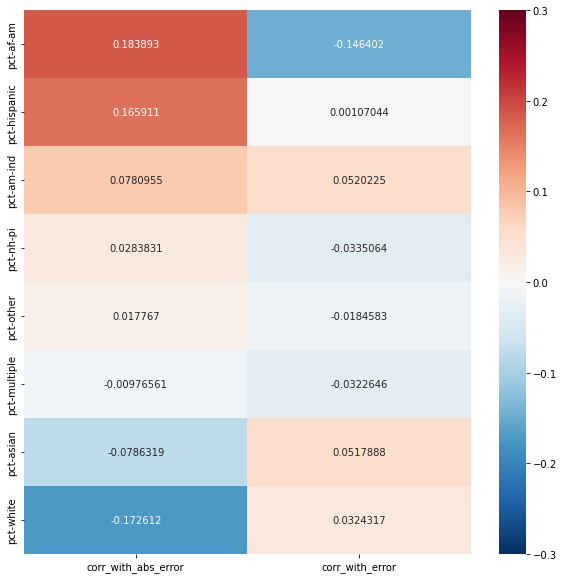

In [32]:
# add columns to df_test for error and absolute error
df_test["error"] = y_pred - y_test
df_test["abs_error"] = abs(df_test["error"])
corr_test_vars = ["abs_error", "error"]

# calculate correlation
corr = (
    df_test.loc[:, corr_test_vars + race_cols].corr().loc[race_cols, corr_test_vars]
).rename(columns={"abs_error": "corr_with_abs_error", "error": "corr_with_error"})

# plot correlation heatmap
plt.figure(figsize=FIGSIZE)
sns.heatmap(
    corr.sort_values("corr_with_abs_error", ascending=False),
    annot=True,
    fmt="g",
    cmap="RdBu_r",
    vmin=-0.3,
    vmax=0.3,
)

**<span style="color:green">Takeaways</span>** 

- <span style="color:green">Neighborhoods with a higher percentage of white residents tend to have lower absolute error, meaning the model is more accurate. The same is true for percent Asian residents.</span>

- <span style="color:green">Neighborhoods with a higher percentage of African American residents tend to have higher absolute error, meaning the model is less accurate. The same is true for percent Hispanic residents.</span>

- <span style="color:green">The above indicates that the model is more accurate for the same groups that we saw earlier correlate with overall lower eviction rates, lower poverty rates, and higher median income. This could be problematic because it means the model does not perform quite as well for exactly the groups that the non-profit may be hoping to serve. However, these correlations are not very strong.</span>

<span style="color:green">Generate at least one other visual that helps to compare error rates between different racial groups. You could also explore another method of determining whether error is dependent on race percentages, such as fitting another model.</span>

<AxesSubplot:>

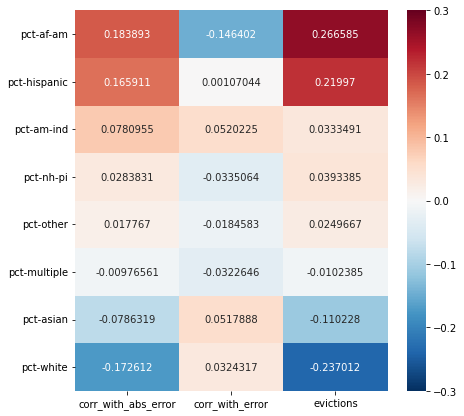

In [33]:
# Is the difference in absolute error by race just a reflection of the model performing worse when evictions are higher?
corr_test_vars = ["abs_error", "error", "evictions"]

# calculate correlation
corr = (
    df_test.loc[:, corr_test_vars + race_cols].corr().loc[race_cols, corr_test_vars]
).rename(columns={"abs_error": "corr_with_abs_error", "error": "corr_with_error"})

# plot correlation heatmap
plt.figure(figsize=(7, 7))  # (5, 8))
sns.heatmap(
    corr.sort_values("corr_with_abs_error", ascending=False),
    annot=True,
    fmt="g",
    cmap="RdBu_r",
    vmin=-0.3,
    vmax=0.3,
)

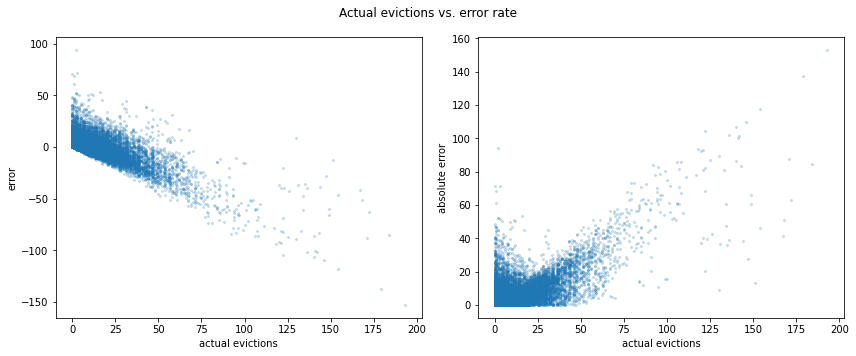

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(df_test["evictions"], df_test["error"], s=4, alpha=0.2)
axes[0].set_xlabel("actual evictions")
axes[0].set_ylabel("error")

axes[1].scatter(df_test["evictions"], df_test["abs_error"], s=4, alpha=0.2)
axes[1].set_xlabel("actual evictions")
axes[1].set_ylabel("absolute error")

plt.suptitle("Actual evictions vs. error rate")
plt.tight_layout()
plt.show()

**<span style="color:green">Takeaways</span>** 

- <span style="color:green">The correlation between each race variable and absolute error matches the pattern of correlation between each race variable and the actual rate of evictions. As shown in the plots of evictions v. error, the model generally performs worse when evictions are higher, and tends to underpredict evictions when eviction rates are high. Interestingly, the absolute error seems to decrease up to point (around 25), and beyond that increases as evictions increase.</span>

- <span style="color:green">The correlation between each race variable and absolute error may actually just be a reflection of the model's poorer performance when evictions are higher, combined with the correlation between eviction rate and race.</span>

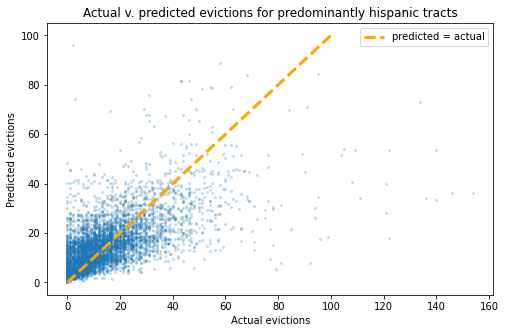

In [35]:
# Produce a scatterplot showing error for predominantly hispanic tracts
fig, ax = plt.subplots(figsize=(8, 5))

df_test["pred"] = y_pred

hisp = df_test[df_test["pct-hispanic"] > 50]
hisp = hisp.sort_values("evictions")

plt.scatter(hisp["evictions"], hisp["pred"], s=4, alpha=0.2)
plt.plot(
    [0, 100], [0, 100], "--", linewidth=3, color="orange", label="predicted = actual"
)
plt.xlabel("Actual evictions")
plt.ylabel("Predicted evictions")
plt.legend()
plt.title("Actual v. predicted evictions for predominantly hispanic tracts")

plt.show()

In [36]:
# what percent are underpredicted?
(hisp["pred"] < hisp["evictions"]).mean()

0.42064582617657165

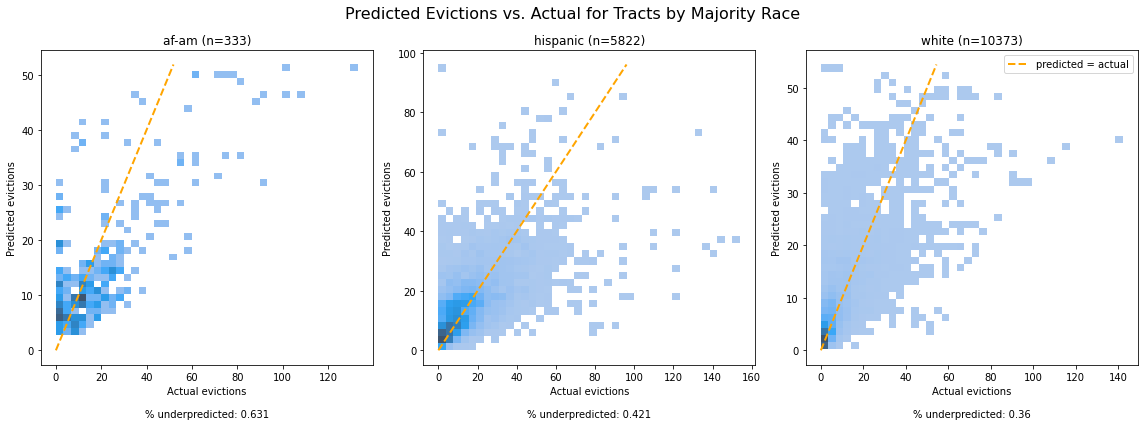

In [37]:
# Produce the same plot side by side for different populations
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle(
    "Predicted Evictions vs. Actual for Tracts by Majority Race",
    fontsize=16,
)


def plot_error_for_pop(pop_name, ax, thresh=50):
    pop = df_test[df_test[f"pct-{pop_name}"] > thresh]

    sns.histplot(data=pop, x="evictions", y="pred", ax=ax, bins=40)
    ax.plot(
        [0, max(pop.pred)],
        [0, max(pop.pred)],
        "--",
        linewidth=2,
        color="orange",
        label="predicted = actual",
    )
    ax.set_xlabel(
        f"Actual evictions\n\n% underpredicted: {(pop.pred < pop.evictions).mean().round(3)}"
    )
    ax.set_ylabel("Predicted evictions")
    ax.set_title(f"{pop_name} (n={len(pop)})")


for ax, pop_name in zip(axes, ["af-am", "hispanic", "white"]):
    plot_error_for_pop(pop_name, ax=ax)

plt.legend()
plt.tight_layout()

In [38]:
basic_metrics = pd.DataFrame(
    index=[
        "pct_underpredicted",
        "avg_error",
        "avg_abs_error",
        "avg_evictions",
        "count",
    ]
)

for var in race_cols:
    pop = df_test[df_test[var] > 50]
    basic_metrics[var] = [
        (pop.pred < pop.evictions).mean(),
        pop.error.mean(),
        pop.abs_error.mean(),
        pop.evictions.mean(),
        len(pop),
    ]

basic_metrics.round(3)

,pct-white,pct-af-am,pct-hispanic,pct-am-ind,pct-asian,pct-nh-pi,pct-multiple,pct-other
pct_underpredicted,0.360,0.631,0.421,NaN,0.214,NaN,NaN,NaN
avg_error,0.863,-3.936,0.331,NaN,3.247,NaN,NaN,NaN
avg_abs_error,4.512,10.187,7.625,NaN,4.397,NaN,NaN,NaN
avg_evictions,7.163,19.042,14.853,NaN,5.437,NaN,NaN,NaN
count,10373.000,333.000,5822.000,0.0,678.000,0.0,0.0,0.0


<span style="color:green">**End of activity, wait for group to reconvene and discuss**</span>

***

 - [ ] **D.3 Metric selection**: Have we considered the effects of optimizing for our defined metrics and considered additional metrics?

In the Random Forest model above, we used `mse` (mean-squared error) as the loss function. Mean-squared error is affected more by outliers than mean-absolute error. 

 - [ ] **D.4 Explainability**: Can we explain in understandable terms a decision the model made in cases where a justification is needed?

In [39]:
model_pipeline.named_steps["model"].feature_importances_
feature_importance = pd.DataFrame.from_dict(
    {
        "features": FEATURE_VARS,
        "importance": model_pipeline.named_steps["model"].feature_importances_,
    }
)
print(
    feature_importance.sort_values("importance", ascending=False).reset_index(drop=True)
)

                     features  importance
0  renter-occupied-households    0.425646
1       median-property-value    0.215394
2                poverty-rate    0.078628
3                        year    0.067333
4                  population    0.053983
5                 rent-burden    0.045774
6     median-household-income    0.040545
7           median-gross-rent    0.040022
8         pct-renter-occupied    0.032674


 - [ ] **D.5 Communicate bias**: Have we communicated the shortcomings, limitations, and biases of the model to relevant stakeholders in ways that can be generally understood?

We won't go into communicate bias in detail in this exercise.

## E. Deployment

 - [ ] **E.1 Monitoring and evaluation:** How are we planning to monitor the model and its impacts after it is deployed (e.g., performance monitoring, regular audit of sample predictions, human review of high-stakes decisions, reviewing downstream impacts of errors or low-confidence decisions, testing for concept drift)?

 - [ ] **E.2 Redress**: Have we discussed with our organization a plan for response if users are harmed by the results (e.g., how does the data science team evaluate these cases and update analysis and models to prevent future harm)?

### <span style="color:green">*Discussion*</span>


<span style="color:green">*E.1 and E.2:* Think about how you could monitor/evaluate the model moving forward, and put steps for redress in place.</span>

- <span style="color:green">What are some possible real-world consequences of the model performing poorly / making mistakes? What is the potential harm or inequity from incorrect model estimates?</span>

- <span style="color:green">How might you determine what the performance cutoff is for the model being good enough to use in practice?</span>

- <span style="color:green">What metric could you use for the above? What are some of the pros and cons of different matrics? Think about the consequences of false positives vs. false negatives in practice. Is one less desirable than the other, and how can that be reflected in your metric?</span>

- <span style="color:green">If/when the model is deployed in practice, will there be any human review of the model's decisions? In which cases will there be human review, and how will that be integrated?</span>

 - [ ] **E.3 Roll back**: Is there a way to turn off or roll back the model in production if necessary?

We won't go into roll back in detail in this exercise.

 - [ ] **E.4 Unintended use**: Have we taken steps to identify and prevent unintended uses and abuse of the model and do we have a plan to monitor these once the model is deployed?

We won't go into unintended use in detail in this exercise.

*Data Science Ethics Checklist generated with [deon](http://deon.drivendata.org).*